# Ungraded Lab: Predicting Sunspots with Neural Networks

In the remaining labs for this week, you will move away from synthetic time series and start building models for real world data. In particular, you will train on the [Sunspots](https://www.kaggle.com/datasets/robervalt/sunspots) dataset: a monthly record of sunspot numbers from January 1749 to July 2018. You will first build a deep neural network here composed of dense layers. This will act as your baseline so you can compare it to the next lab where you will use a more complex architecture.

Let's begin!

## Imports

You will use the same imports as before with the addition of the [csv](https://docs.python.org/3/library/csv.html) module. You will need this to parse the CSV file containing the dataset.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

2024-10-10 15:10:23.055933: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 15:10:23.067629: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 15:10:23.080979: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 15:10:23.084562: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 15:10:23.094605: I tensorflow/core/platform/cpu_feature_guar

## Utilities

You will only have the `plot_series()` dataset here because you no longer need the synthetic data generation functions.

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

You can now download the dataset and inspect the contents. The link in class is from Laurence's repo but we also hosted it in the link below.

In [3]:
# Download the dataset
!wget -P data/ -nc https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

File ‘data/Sunspots.csv’ already there; not retrieving.



Running the cell below, you'll see that there are only three columns in the dataset:
1. untitled column containing the month number
2. Date which has the format `YYYY-MM-DD`
3. Mean Total Sunspot Number

In [4]:
# Preview the dataset
!head data/Sunspots.csv

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5


For this lab and the next, you will only need the month number and the mean total sunspot number. You will load those into memory and convert it to arrays that represents a time series.

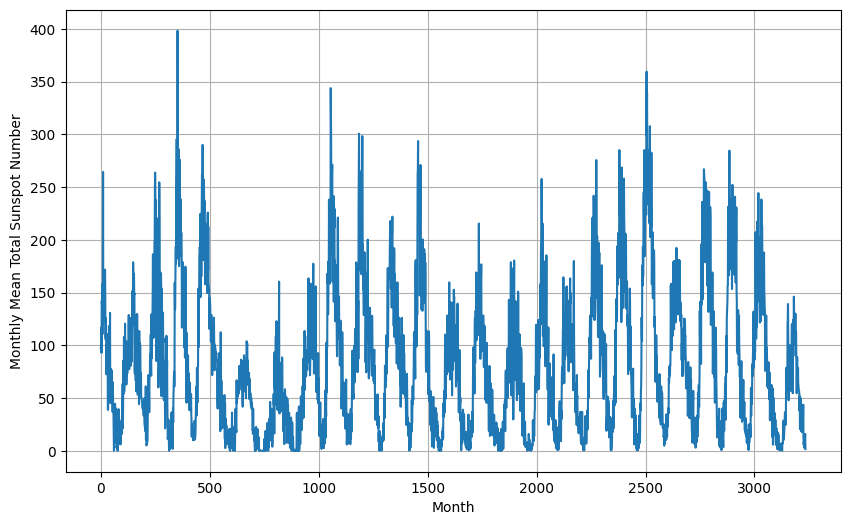

In [5]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./data/Sunspots.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

## Split the Dataset

Next, you will split the dataset into training and validation sets. There are 3235 points in the dataset and you will use the first 3000 for training.

In [6]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

You can then prepare the dataset windows as before. The window size is set to 30 points (equal to 2.5 years) but feel free to change later on if you want to experiment.

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size)
    
    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)
    
    return dataset

In [8]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

I0000 00:00:1728583825.234438  295933 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728583825.259030  295933 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728583825.259078  295933 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728583825.262852  295933 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728583825.262933  295933 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

## Build the Model

The model will be 3-layer dense network as shown below.

In [9]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)),
    tf.keras.layers.Dense(30, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,251 (4.89 KB)

 Trainable params: 1,251 (4.89 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

You can pick a learning rate by running the same learning rate scheduler code from previous labs.

In [10]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


I0000 00:00:1728583826.623391  296137 service.cc:146] XLA service 0x7fca18009a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728583826.623532  296137 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-10-10 15:10:26.654321: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-10 15:10:26.722345: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


     46/Unknown 1s 3ms/step - loss: 72.6592

I0000 00:00:1728583827.214599  296137 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 73.8635 - learning_rate: 1.0000e-08
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 73.0830 - learning_rate: 1.1220e-08
Epoch 3/100
55/93 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 70.9891

2024-10-10 15:10:27.769359: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-10 15:10:27.769416: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-10 15:10:27.769428: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:27.769448: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, tra

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 72.1843 - learning_rate: 1.2589e-08
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 71.1755 - learning_rate: 1.4125e-08
Epoch 5/100
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 68.9259

2024-10-10 15:10:28.008561: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:28.008636: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:28.117561: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-10 15:10:28.117609: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:28.117630: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 70.0358 - learning_rate: 1.5849e-08
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 68.7418 - learning_rate: 1.7783e-08
Epoch 7/100
50/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 66.3285

2024-10-10 15:10:28.221316: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:28.221379: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:28.324736: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:28.324797: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 67.2781 - learning_rate: 1.9953e-08
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 65.6068 - learning_rate: 2.2387e-08
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 63.7091 - learning_rate: 2.5119e-08
Epoch 10/100


2024-10-10 15:10:28.427746: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:28.427802: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:28.525430: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-10 15:10:28.525475: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:28.525497: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:28.622722: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:28.622785: I tensorflow/

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 61.5496 - learning_rate: 2.8184e-08
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 59.0795 - learning_rate: 3.1623e-08
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 56.2595 - learning_rate: 3.5481e-08
Epoch 13/100


2024-10-10 15:10:28.716837: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:28.716896: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:28.812196: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:28.812260: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:28.912781: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:28.912842: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 53.0721 - learning_rate: 3.9811e-08
Epoch 14/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 49.4935 - learning_rate: 4.4668e-08
Epoch 15/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 45.5476 - learning_rate: 5.0119e-08
Epoch 16/100


2024-10-10 15:10:29.013798: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:29.013881: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:29.112770: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:29.112848: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:29.208880: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:29.208940: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 41.3779 - learning_rate: 5.6234e-08
Epoch 17/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 37.1869 - learning_rate: 6.3096e-08
Epoch 18/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 33.3977 - learning_rate: 7.0795e-08
Epoch 19/100


2024-10-10 15:10:29.305563: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-10 15:10:29.305612: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:29.305634: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:29.401616: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:29.401679: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:29.497074: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:29.497133: I tensorflow/

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30.3193 - learning_rate: 7.9433e-08
Epoch 20/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 28.2024 - learning_rate: 8.9125e-08
Epoch 21/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 26.8464 - learning_rate: 1.0000e-07
Epoch 22/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.1985

2024-10-10 15:10:29.597883: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:29.597942: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:29.692026: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:29.692091: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:29.784543: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:29.784606: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 25.9935 - learning_rate: 1.1220e-07
Epoch 23/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 25.4653 - learning_rate: 1.2589e-07
Epoch 24/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 25.0602 - learning_rate: 1.4125e-07
Epoch 25/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.4510

2024-10-10 15:10:29.880045: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:29.880109: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:29.976370: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:29.976423: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:30.070042: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:30.070102: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 24.7188 - learning_rate: 1.5849e-07
Epoch 26/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 24.3951 - learning_rate: 1.7783e-07
Epoch 27/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 24.0752 - learning_rate: 1.9953e-07
Epoch 28/100


2024-10-10 15:10:30.165773: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:30.165826: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:30.263344: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:30.263403: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:30.360813: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:30.360872: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 23.7616 - learning_rate: 2.2387e-07
Epoch 29/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23.4647 - learning_rate: 2.5119e-07
Epoch 30/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 23.2043 - learning_rate: 2.8184e-07


2024-10-10 15:10:30.459037: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:30.459096: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:30.559570: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:30.559631: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:30.656283: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:30.656356: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


Epoch 31/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 22.9561 - learning_rate: 3.1623e-07
Epoch 32/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 22.7305 - learning_rate: 3.5481e-07
Epoch 33/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 22.5270 - learning_rate: 3.9811e-07
Epoch 34/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.7618

2024-10-10 15:10:30.752528: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:30.752586: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:30.845318: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-10 15:10:30.845367: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:30.845389: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:30.938222: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:30.938282: I tensorflow/

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22.3510 - learning_rate: 4.4668e-07
Epoch 35/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 22.1781 - learning_rate: 5.0119e-07
Epoch 36/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 22.0198 - learning_rate: 5.6234e-07
Epoch 37/100


2024-10-10 15:10:31.037560: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:31.037622: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:31.133289: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:31.133345: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:31.234207: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:31.234271: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.8742 - learning_rate: 6.3096e-07
Epoch 38/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 21.7291 - learning_rate: 7.0795e-07
Epoch 39/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.5995 - learning_rate: 7.9433e-07
Epoch 40/100


2024-10-10 15:10:31.340173: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:31.340234: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:31.434965: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:31.435026: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:31.534539: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:31.534601: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 21.4759 - learning_rate: 8.9125e-07
Epoch 41/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.3481 - learning_rate: 1.0000e-06
Epoch 42/100
57/93 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 21.2450

2024-10-10 15:10:31.634130: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:31.634201: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:31.754443: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:31.754498: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 21.2224 - learning_rate: 1.1220e-06
Epoch 43/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 21.0894 - learning_rate: 1.2589e-06
Epoch 44/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 20.9512 - learning_rate: 1.4125e-06
Epoch 45/100


2024-10-10 15:10:31.850273: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:31.850334: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:31.946810: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:31.946869: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:32.043464: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:32.043526: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.8097 - learning_rate: 1.5849e-06
Epoch 46/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.6657 - learning_rate: 1.7783e-06
Epoch 47/100
55/93 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 20.5347

2024-10-10 15:10:32.146432: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:32.146507: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:32.252234: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:32.252299: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:32.349045: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:32.349108: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 20.5137 - learning_rate: 1.9953e-06
Epoch 48/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 20.3558 - learning_rate: 2.2387e-06
Epoch 49/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 20.1914 - learning_rate: 2.5119e-06
Epoch 50/100
44/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.0836

2024-10-10 15:10:32.444901: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:32.444964: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:32.541978: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:32.542040: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.0254 - learning_rate: 2.8184e-06
Epoch 51/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 19.8402 - learning_rate: 3.1623e-06
Epoch 52/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 19.6403 - learning_rate: 3.5481e-06


2024-10-10 15:10:32.652922: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:32.652984: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:32.751791: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:32.751854: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:32.849280: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:32.849343: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


Epoch 53/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 19.4305 - learning_rate: 3.9811e-06
Epoch 54/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.2324 - learning_rate: 4.4668e-06
Epoch 55/100
51/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.0376

2024-10-10 15:10:32.948097: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:32.948192: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:33.053153: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:33.053207: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.0606 - learning_rate: 5.0119e-06
Epoch 56/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.8775 - learning_rate: 5.6234e-06
Epoch 57/100
46/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.6457

2024-10-10 15:10:33.153157: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:33.153214: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:33.255098: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:33.255166: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.6647 - learning_rate: 6.3096e-06
Epoch 58/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 18.5056 - learning_rate: 7.0795e-06
Epoch 59/100
49/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.3238

2024-10-10 15:10:33.363952: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:33.364016: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:33.465861: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:33.465922: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.3679 - learning_rate: 7.9433e-06
Epoch 60/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.2227 - learning_rate: 8.9125e-06
Epoch 61/100
51/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.9599

2024-10-10 15:10:33.573936: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:33.574005: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:33.712507: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:33.712567: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.0392 - learning_rate: 1.0000e-05
Epoch 62/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.9341 - learning_rate: 1.1220e-05
Epoch 63/100
52/93 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 17.5633

2024-10-10 15:10:33.815242: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:33.815310: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:33.917995: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:33.918055: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.7197 - learning_rate: 1.2589e-05
Epoch 64/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.5465 - learning_rate: 1.4125e-05
Epoch 65/100
50/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.2710

2024-10-10 15:10:34.020296: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:34.020360: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:34.126318: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-10 15:10:34.126370: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:34.126391: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.4390 - learning_rate: 1.5849e-05
Epoch 66/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.3623 - learning_rate: 1.7783e-05
Epoch 67/100
50/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.1522

2024-10-10 15:10:34.229360: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:34.229436: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:34.338328: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:34.338391: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.3417 - learning_rate: 1.9953e-05
Epoch 68/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.2741 - learning_rate: 2.2387e-05
Epoch 69/100
51/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.9861

2024-10-10 15:10:34.444931: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:34.444998: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:34.554017: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:34.554078: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.2106 - learning_rate: 2.5119e-05
Epoch 70/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.1589 - learning_rate: 2.8184e-05
Epoch 71/100
43/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7885

2024-10-10 15:10:34.656684: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:34.656742: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:34.763776: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:34.763837: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.1244 - learning_rate: 3.1623e-05
Epoch 72/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.0813 - learning_rate: 3.5481e-05
Epoch 73/100
37/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.6665

2024-10-10 15:10:34.893781: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:34.893847: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:35.033917: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:35.033979: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.1073 - learning_rate: 3.9811e-05
Epoch 74/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.1826 - learning_rate: 4.4668e-05
Epoch 75/100
47/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.2839

2024-10-10 15:10:35.188480: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:35.188576: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:35.300955: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:35.301012: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.3707 - learning_rate: 5.0119e-05
Epoch 76/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.3182 - learning_rate: 5.6234e-05
Epoch 77/100
42/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.8044

2024-10-10 15:10:35.414568: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:35.414633: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:35.536576: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:35.536648: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.6334 - learning_rate: 6.3096e-05
Epoch 78/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.8472 - learning_rate: 7.0795e-05
Epoch 79/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.5492

2024-10-10 15:10:35.660143: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:35.660203: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:35.812585: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:35.812670: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.5083 - learning_rate: 7.9433e-05
Epoch 80/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.2749 - learning_rate: 8.9125e-05
Epoch 81/100
45/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.3552

2024-10-10 15:10:35.937798: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:35.937857: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:36.046522: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:36.046587: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.4112 - learning_rate: 1.0000e-04
Epoch 82/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.3673 - learning_rate: 1.1220e-04
Epoch 83/100
43/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.5802

2024-10-10 15:10:36.163470: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:36.163539: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:36.286931: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:36.286995: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.7976 - learning_rate: 1.2589e-04
Epoch 84/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.7354 - learning_rate: 1.4125e-04
Epoch 85/100
47/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.1250

2024-10-10 15:10:36.409632: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:36.409690: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:36.526359: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:36.526420: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.3480 - learning_rate: 1.5849e-04
Epoch 86/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.0482 - learning_rate: 1.7783e-04
Epoch 87/100
48/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.9412

2024-10-10 15:10:36.639843: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:36.639933: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:36.758210: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:36.758274: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.8612 - learning_rate: 1.9953e-04
Epoch 88/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.0707 - learning_rate: 2.2387e-04
Epoch 89/100
49/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23.3960

2024-10-10 15:10:36.873030: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:36.873101: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:36.990274: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:36.990338: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22.3980 - learning_rate: 2.5119e-04
Epoch 90/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.2326 - learning_rate: 2.8184e-04
Epoch 91/100
43/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.1579

2024-10-10 15:10:37.099170: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:37.099234: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:37.210338: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:37.210403: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.4384 - learning_rate: 3.1623e-04
Epoch 92/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.8022 - learning_rate: 3.5481e-04
Epoch 93/100
46/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.6546

2024-10-10 15:10:37.330533: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:37.330651: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:37.447178: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:37.447240: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.2780 - learning_rate: 3.9811e-04
Epoch 94/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.5287 - learning_rate: 4.4668e-04
Epoch 95/100
46/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.4195

2024-10-10 15:10:37.563978: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:37.564055: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:37.684486: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:37.684548: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.4661 - learning_rate: 5.0119e-04
Epoch 96/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.3543 - learning_rate: 5.6234e-04
Epoch 97/100
48/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.8987

2024-10-10 15:10:37.800179: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:37.800256: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:37.920103: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:37.920167: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.3155 - learning_rate: 6.3096e-04
Epoch 98/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.3701 - learning_rate: 7.0795e-04
Epoch 99/100
48/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.5506

2024-10-10 15:10:38.029930: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:38.029994: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:38.138975: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:38.139039: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.6164 - learning_rate: 7.9433e-04
Epoch 100/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28.3003 - learning_rate: 8.9125e-04


2024-10-10 15:10:38.246643: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:38.246701: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:38.367858: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:38.367918: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


(1e-08, 0.001, 0.0, 100.0)

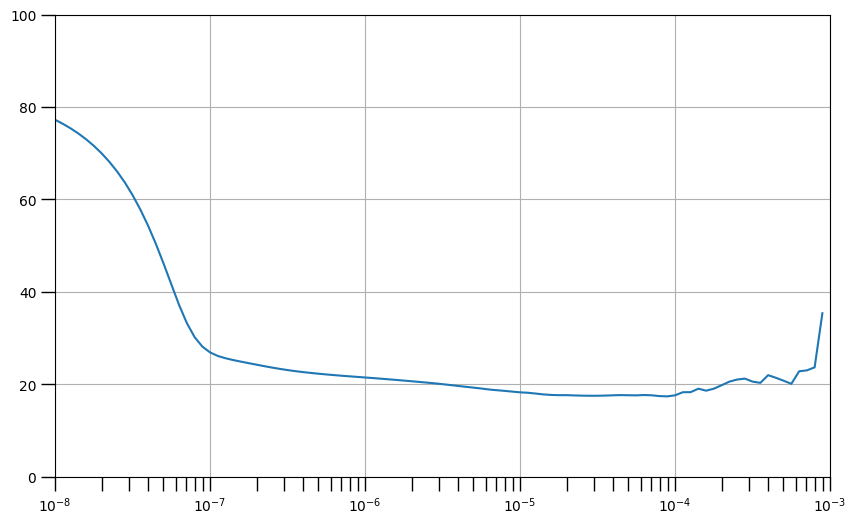

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

## Train the Model

Once you've picked a learning rate, you can rebuild the model and start training.

In [12]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)),
    tf.keras.layers.Dense(30, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [13]:
# Set the learning rate
learning_rate = 2e-5

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 33.6222 - mae: 34.1168
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.6885 - mae: 21.1820
Epoch 3/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16.2579 - mae: 16.7578

2024-10-10 15:10:40.012267: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:40.012344: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:40.170601: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:40.170660: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.6039 - mae: 20.0977
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.2035 - mae: 19.6983
Epoch 5/100
47/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.7717 - mae: 19.2662

2024-10-10 15:10:40.286236: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:40.286293: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:40.424894: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:40.424958: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.7091 - mae: 19.2030
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.4423 - mae: 18.9346
Epoch 7/100
44/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.2230 - mae: 18.7152

2024-10-10 15:10:40.539561: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:40.539619: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:40.659298: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:40.659362: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.2300 - mae: 18.7221
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.0296 - mae: 18.5230
Epoch 9/100
41/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.7721 - mae: 18.2630

2024-10-10 15:10:40.780684: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:40.780747: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:40.902131: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:40.902190: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.8582 - mae: 18.3501
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.6695 - mae: 18.1606
Epoch 11/100
41/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.4041 - mae: 17.8926

2024-10-10 15:10:41.025412: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:41.025472: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:41.154491: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:41.154554: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.5689 - mae: 18.0588
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.4303 - mae: 17.9199
Epoch 13/100
44/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.1809 - mae: 17.6696

2024-10-10 15:10:41.279887: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:41.279944: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:41.401408: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:41.401469: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.3757 - mae: 17.8657
Epoch 14/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.2951 - mae: 17.7865
Epoch 15/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.9506 - mae: 13.4446

2024-10-10 15:10:41.520533: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:41.520593: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:41.663770: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:41.663830: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.2129 - mae: 17.7042
Epoch 16/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.1775 - mae: 17.6677
Epoch 17/100
45/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.9608 - mae: 17.4499

2024-10-10 15:10:41.782719: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:41.782777: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:41.908514: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:41.908570: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.1515 - mae: 17.6418
Epoch 18/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.0984 - mae: 17.5899
Epoch 19/100
39/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8272 - mae: 17.3190

2024-10-10 15:10:42.028056: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:42.028118: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:42.143776: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:42.143835: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.0613 - mae: 17.5534
Epoch 20/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.0319 - mae: 17.5225
Epoch 21/100
44/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7735 - mae: 17.2617

2024-10-10 15:10:42.269989: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:42.270049: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:42.392798: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:42.392857: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.9986 - mae: 17.4879
Epoch 22/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.9576 - mae: 17.4485
Epoch 23/100
39/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.6701 - mae: 17.1597

2024-10-10 15:10:42.516132: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:42.516196: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:42.653247: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:42.653314: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.9388 - mae: 17.4282
Epoch 24/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.9183 - mae: 17.4080
Epoch 25/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12.9383 - mae: 13.4251

2024-10-10 15:10:42.796247: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:42.796330: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:42.948251: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:42.948315: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.8902 - mae: 17.3809
Epoch 26/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8581 - mae: 17.3479
Epoch 27/100
37/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.5614 - mae: 17.0512

2024-10-10 15:10:43.096584: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:43.096645: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:43.218891: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:43.218953: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8314 - mae: 17.3218
Epoch 28/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8247 - mae: 17.3161
Epoch 29/100
42/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.5827 - mae: 17.0739

2024-10-10 15:10:43.356587: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:43.356649: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:43.484366: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-10 15:10:43.484414: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:43.484436: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8151 - mae: 17.3068
Epoch 30/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7907 - mae: 17.2823
Epoch 31/100
40/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.5308 - mae: 17.0222

2024-10-10 15:10:43.612953: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:43.613015: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:43.742084: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:43.742146: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.7810 - mae: 17.2728
Epoch 32/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7496 - mae: 17.2411
Epoch 33/100
41/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.5254 - mae: 17.0163

2024-10-10 15:10:43.899915: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:43.899981: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:44.037188: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:44.037259: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7677 - mae: 17.2593
Epoch 34/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7700 - mae: 17.2613
Epoch 35/100
40/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.5214 - mae: 17.0116

2024-10-10 15:10:44.168567: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:44.168652: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:44.298122: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:44.298188: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7563 - mae: 17.2475
Epoch 36/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7440 - mae: 17.2339
Epoch 37/100
41/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4842 - mae: 16.9747

2024-10-10 15:10:44.433338: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:44.433406: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:44.565899: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:44.565964: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7113 - mae: 17.2022
Epoch 38/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7376 - mae: 17.2267
Epoch 39/100
43/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.5575 - mae: 17.0448

2024-10-10 15:10:44.700599: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:44.700671: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:44.829783: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:44.829845: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7362 - mae: 17.2249
Epoch 40/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7305 - mae: 17.2189
Epoch 41/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.7939 - mae: 13.2878

2024-10-10 15:10:44.960513: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:44.960578: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:45.101899: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:45.101961: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7231 - mae: 17.2118
Epoch 42/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7170 - mae: 17.2055
Epoch 43/100
43/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.5449 - mae: 17.0329

2024-10-10 15:10:45.225054: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:45.225116: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:45.352267: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:45.352343: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7133 - mae: 17.2018
Epoch 44/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.6859 - mae: 17.1737
Epoch 45/100
41/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4804 - mae: 16.9668

2024-10-10 15:10:45.481024: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:45.481088: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:45.603728: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:45.603788: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.6777 - mae: 17.1653
Epoch 46/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.6715 - mae: 17.1585
Epoch 47/100
44/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4815 - mae: 16.9705

2024-10-10 15:10:45.737849: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:45.737913: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:45.861570: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:45.861633: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.6627 - mae: 17.1517
Epoch 48/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.6548 - mae: 17.1423
Epoch 49/100
44/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4780 - mae: 16.9640

2024-10-10 15:10:45.986271: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:45.986329: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:46.122486: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:46.122546: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.6551 - mae: 17.1421
Epoch 50/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.6483 - mae: 17.1349
Epoch 51/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.8575 - mae: 13.3573

2024-10-10 15:10:46.245287: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:46.245349: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:46.388334: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:46.388400: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.6505 - mae: 17.1376
Epoch 52/100
93/93 ━━━━━━━━━━━━━━━━━━━━ -0s -4460us/step - loss: 16.6369 - mae: 17.1259
Epoch 53/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.8742 - mae: 13.3738

2024-10-10 15:10:46.516669: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:46.516730: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:46.112112: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:46.112206: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.6187 - mae: 17.1085
Epoch 54/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.6078 - mae: 17.0972
Epoch 55/100
33/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.3934 - mae: 16.8836

2024-10-10 15:10:46.242361: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:46.242425: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:46.365452: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:46.365517: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.5982 - mae: 17.0872
Epoch 56/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.5827 - mae: 17.0714
Epoch 57/100
38/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.3657 - mae: 16.8548

2024-10-10 15:10:46.525345: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:46.525418: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:46.651377: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:46.651454: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.5773 - mae: 17.0659
Epoch 58/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.5621 - mae: 17.0504
Epoch 59/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.9018 - mae: 13.4012

2024-10-10 15:10:46.791470: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:46.791527: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:46.954632: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:46.954693: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.5597 - mae: 17.0474
Epoch 60/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.5517 - mae: 17.0393
Epoch 61/100
41/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.3374 - mae: 16.8256

2024-10-10 15:10:47.092498: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:47.092566: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:47.214446: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:47.214505: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.5371 - mae: 17.0250
Epoch 62/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.5344 - mae: 17.0220
Epoch 63/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.8987 - mae: 13.3977

2024-10-10 15:10:47.343763: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:47.343830: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:47.484322: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:47.484400: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.5251 - mae: 17.0127
Epoch 64/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.5213 - mae: 17.0089
Epoch 65/100
38/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.3030 - mae: 16.7911

2024-10-10 15:10:47.623547: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:47.623612: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.5133 - mae: 17.0010
Epoch 66/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.5002 - mae: 16.9877
Epoch 67/100
44/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.3195 - mae: 16.8072

2024-10-10 15:10:47.887711: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:47.887785: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:48.021539: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:48.021600: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.5020 - mae: 16.9896
Epoch 68/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4985 - mae: 16.9862
Epoch 69/100
42/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.2936 - mae: 16.7826

2024-10-10 15:10:48.146101: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:48.146171: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:48.274811: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:48.274879: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4920 - mae: 16.9804
Epoch 70/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4859 - mae: 16.9744
Epoch 71/100
40/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.2639 - mae: 16.7527

2024-10-10 15:10:48.399975: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:48.400036: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:48.526391: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:48.526451: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4739 - mae: 16.9620
Epoch 72/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4623 - mae: 16.9501
Epoch 73/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.8763 - mae: 13.3741

2024-10-10 15:10:48.657035: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:48.657099: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:48.797865: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:48.797924: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4602 - mae: 16.9482
Epoch 74/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4529 - mae: 16.9412
Epoch 75/100
43/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.2545 - mae: 16.7444

2024-10-10 15:10:48.919463: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:48.919524: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:49.047250: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:49.047309: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4497 - mae: 16.9390
Epoch 76/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4396 - mae: 16.9287
Epoch 77/100
43/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.2285 - mae: 16.7176

2024-10-10 15:10:49.169632: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:49.169692: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:49.289629: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:49.289690: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4319 - mae: 16.9205
Epoch 78/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4296 - mae: 16.9183
Epoch 79/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 12.8505 - mae: 13.3487

2024-10-10 15:10:49.409162: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:49.409230: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:49.551719: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:49.551784: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.4261 - mae: 16.9145
Epoch 80/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4187 - mae: 16.9069
Epoch 81/100
38/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.1834 - mae: 16.6718

2024-10-10 15:10:49.704998: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:49.705060: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:49.844493: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:49.844556: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4160 - mae: 16.9042
Epoch 82/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4174 - mae: 16.9051
Epoch 83/100
43/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.2031 - mae: 16.6910

2024-10-10 15:10:49.978792: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:49.978849: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:50.106729: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4121 - mae: 16.8997
Epoch 84/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4069 - mae: 16.8949
Epoch 85/100
43/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.1908 - mae: 16.6787

2024-10-10 15:10:50.231427: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:50.231485: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:50.362513: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:50.362574: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4029 - mae: 16.8908
Epoch 86/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.3991 - mae: 16.8871
Epoch 87/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.8070 - mae: 13.3058

2024-10-10 15:10:50.491468: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:50.491528: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:50.642622: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:50.642684: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4010 - mae: 16.8890
Epoch 88/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.3942 - mae: 16.8820
Epoch 89/100
42/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.1728 - mae: 16.6614

2024-10-10 15:10:50.769486: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:50.769548: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:50.889361: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:50.889417: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.3893 - mae: 16.8774
Epoch 90/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.3821 - mae: 16.8703
Epoch 91/100
42/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.1686 - mae: 16.6567

2024-10-10 15:10:51.015331: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:51.015392: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:51.139657: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:51.139714: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.3849 - mae: 16.8727
Epoch 92/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.3811 - mae: 16.8691
Epoch 93/100
43/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.1631 - mae: 16.6513

2024-10-10 15:10:51.265493: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:51.265563: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:51.393823: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:51.393889: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.3753 - mae: 16.8632
Epoch 94/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.3741 - mae: 16.8615
Epoch 95/100
41/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.1421 - mae: 16.6288

2024-10-10 15:10:51.521731: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:51.521792: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:51.661292: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:51.661355: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.3670 - mae: 16.8540
Epoch 96/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.3542 - mae: 16.8414
Epoch 97/100
42/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.1380 - mae: 16.6239

2024-10-10 15:10:51.791625: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:51.791687: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:51.916642: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:51.916700: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.3573 - mae: 16.8437
Epoch 98/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.3438 - mae: 16.8304
Epoch 99/100
42/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.1196 - mae: 16.6055

2024-10-10 15:10:52.044093: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:52.044152: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:52.170958: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:52.171021: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.3422 - mae: 16.8285
Epoch 100/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.3261 - mae: 16.8127


2024-10-10 15:10:52.296604: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:52.296661: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325
2024-10-10 15:10:52.426368: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14320852859421762191
2024-10-10 15:10:52.426427: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15603311399486330325


## Model Prediction

Now see if the model generates good results. If you used the default parameters of this notebook, you should see the predictions follow the shape of the ground truth with an MAE of around 15. 

In [14]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset, verbose=0)
    
    return forecast

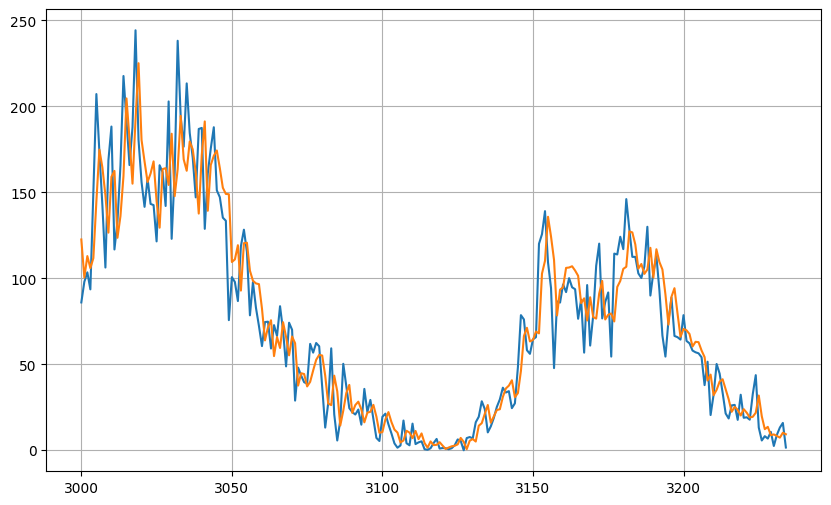

In [15]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [16]:
# Compute the MAE
print(tf.keras.metrics.mae(x_valid, results).numpy())

14.923039


## Wrap Up

In this lab, you built a relatively simple DNN to forecast sunspot numbers for a given month. We encourage you to tweak the parameters or train longer and see the best results you can get. In the next lab, you will build a more complex model and you evaluate if the added complexity translates to better or worse results.